<a href="https://colab.research.google.com/github/simran-padam/CovidImageClassification/blob/main/COVID_Positive_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Covid Hackathon Report**:
<ul type= "none">
  <li> The report attempts to do Image Classification on three types of X-ray images of patients: Covid, Viral Pneumonia and Normal. Various deep learning techniques have been explored to achieve better model accuracy. </li>
  <ul>
  <li>Name: Simran Padam </li>
  <li>UNI: sdp2158 </li>
  <li>Github repo link :https://github.com/simran-padam/CovidImageClassification.git

  <li>Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145
  
 </li>
  </ul>


#### **Model Purpose**:
<ul type= "none">
  <li> The objective of the model is to use deep learning modeling techniques to detect Covid19 affected patients.</li>
  <ul>
  <li> As the dataset contains three type of categories: Covid, Viral Pneumonia and Normal X-ray image of patients. Correct detection of X-ray images will aid the health professionals in screening the patients to see if their lungs are affected by the disease. Identifying the features from the image using pre-trained models will perhaps help us achieve higher accuracy in classification. </li>
  </ul>

## **A. Setup and Data Prep**

In [1]:
def warn(*args,**kwargs):pass
import warnings
warnings.warn=warn

In [2]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [4]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [5]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1911.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-764.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2869.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3146.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3128.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-476.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2741.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2130.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3329.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-489.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2629.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1049.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1808.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1831.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1899.png', 'COVID-19_Radiography_Dataset/COVID/images/CO

In [6]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)
y.head()

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


## **B. Visualization**

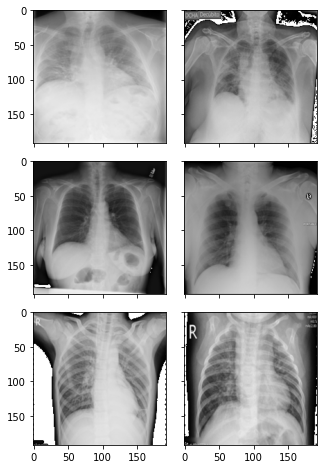

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

cov_img1 = preprocessor(fnames[0][20])
cov_img2 = preprocessor(fnames[0][40])
norm_img1 = preprocessor(fnames[1][30])
norm_img2 = preprocessor(fnames[1][50])
pneum_img1 = preprocessor(fnames[2][10])
pneum_img2 = preprocessor(fnames[2][30])

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3,2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [cov_img1, cov_img2, norm_img1, norm_img2, pneum_img1, pneum_img2]):
    # Iterating over the grid returns the Axes.
    ax.imshow((im * 255).astype(np.uint8))
plt.show()

#### **Comments**:
<ul type= "none">
  <li> The above picture shows the X-rays images of each of the three categories : Covid (Row1), Normal(Row2)and Viral Pneumonia (Row3) respectively. </li>
  <ul>
  <li> We can see for Covid affected patients lungs appear to be blocked/affected, looks differentiated from other two categories. Use of DL techniques will train the models to assist in the category differentiation </li>
  </ul>

In [21]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [22]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [23]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [24]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [25]:
%%capture
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [26]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


## **C. Model Runs**

### *Model 1 : Vanilla model with 12 conv layers; no regularisation*

In [ ]:
import tensorflow as tf
tf.random.set_seed(2345)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2, callbacks=[red_lr]) #for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 666s 10s/step - loss: 1.1000 - accuracy: 0.3540 - val_loss: 1.0566 - val_accuracy: 0.6448 - lr: 0.0010
Epoch 2/5
69/69 [==============================] - 684s 10s/step - loss: 0.7588 - accuracy: 0.6528 - val_loss: 0.6095 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 3/5
69/69 [==============================] - 693s 10s/step - loss: 0.5479 - accuracy: 0.7555 - val_loss: 0.5350 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 4/5
69/69 [==============================] - 689s 10s/step - loss: 0.5154 - accuracy: 0.7724 - val_loss: 0.4884 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 5/5
69/69 [==============================] - 671s 10s/step - loss: 0.4549 - accuracy: 0.7970 - val_loss: 0.4309 - val_accuracy: 0.8215 - lr: 0.0010


In [ ]:
model.save("vanilla_model.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('vanilla_model.h5',compile=False)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feb27d52700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 119s 3s/step


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                        preprocessor_filepath="preprocessor.zip",
                        prediction_submission=prediction_labels
                        )

Insert search tags to help users find your model (optional): v1
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 136

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### *Model 2 : Vanilla model with 12 conv layers and he_normal regularisation*

In [ ]:
import tensorflow as tf
from tensorflow.keras import initializers
tf.random.set_seed(2345)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2, callbacks=[red_lr]) #for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 574s 8s/step - loss: 1.7693 - accuracy: 0.5917 - val_loss: 0.7821 - val_accuracy: 0.7231 - lr: 0.0010
Epoch 2/5
69/69 [==============================] - 592s 9s/step - loss: 0.4301 - accuracy: 0.8349 - val_loss: 0.4599 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 3/5
69/69 [==============================] - 579s 8s/step - loss: 0.3062 - accuracy: 0.8828 - val_loss: 0.2933 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/5
69/69 [==============================] - 577s 8s/step - loss: 0.2519 - accuracy: 0.9106 - val_loss: 0.2485 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 5/5
69/69 [==============================] - 569s 8s/step - loss: 0.2290 - accuracy: 0.9151 - val_loss: 0.4182 - val_accuracy: 0.8397 - lr: 0.0010


In [ ]:
model.save("model_henorm.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model_henorm.h5',compile=False)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_39 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                 

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feacd24aaf0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 81s 2s/step


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                        preprocessor_filepath="preprocessor.zip",
                        prediction_submission=prediction_labels
                        )

Insert search tags to help users find your model (optional): v2
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 156

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### *Model 3 : Vanilla model with 12 conv layers using he_normal regularisation and tuning filters*





In [ ]:
import tensorflow as tf
from tensorflow.keras import initializers
tf.random.set_seed(2345)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(2, 2)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(2, 2)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(2, 2)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=384, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Conv2D(kernel_size=1, filters=384, padding='same', activation='relu',kernel_initializer = "he_normal"),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 4, verbose=1,validation_split=.2, callbacks=[red_lr]) #for callback that automatically adjusts lr

Epoch 1/4
69/69 [==============================] - 547s 8s/step - loss: 0.8976 - accuracy: 0.6382 - val_loss: 0.5544 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 2/4
69/69 [==============================] - 540s 8s/step - loss: 0.4073 - accuracy: 0.8485 - val_loss: 0.4357 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 3/4
69/69 [==============================] - 533s 8s/step - loss: 0.3060 - accuracy: 0.8828 - val_loss: 0.2947 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/4
69/69 [==============================] - 541s 8s/step - loss: 0.2413 - accuracy: 0.9083 - val_loss: 0.2472 - val_accuracy: 0.9016 - lr: 0.0010


In [ ]:
model.save("model_strides.h5", save_format="h5")

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feb4e9558b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 89s 2s/step


In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                        preprocessor_filepath="preprocessor.zip",
                        prediction_submission=prediction_labels
                        )

Insert search tags to help users find your model (optional): v3
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 157

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### *Model 4 : Functional API model*


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(1234)

inputs = keras.Input(shape=(192, 192, 3), name="img")
x = layers.Conv2D(32, 5, activation="relu")(inputs)
x = layers.Conv2D(128, 5, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(128, 5, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(128, 5, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(128, 5, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(128, 5, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(384, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3)(x)

func_model = keras.Model(inputs, outputs, name="first_functional")
func_model.summary()

Model: "first_functional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_112 (Conv2D)            (None, 188, 188, 32  2432        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_113 (Conv2D)            (None, 184, 184, 12  102528      ['conv2d_112[0][0]']             
                                8)                                                 

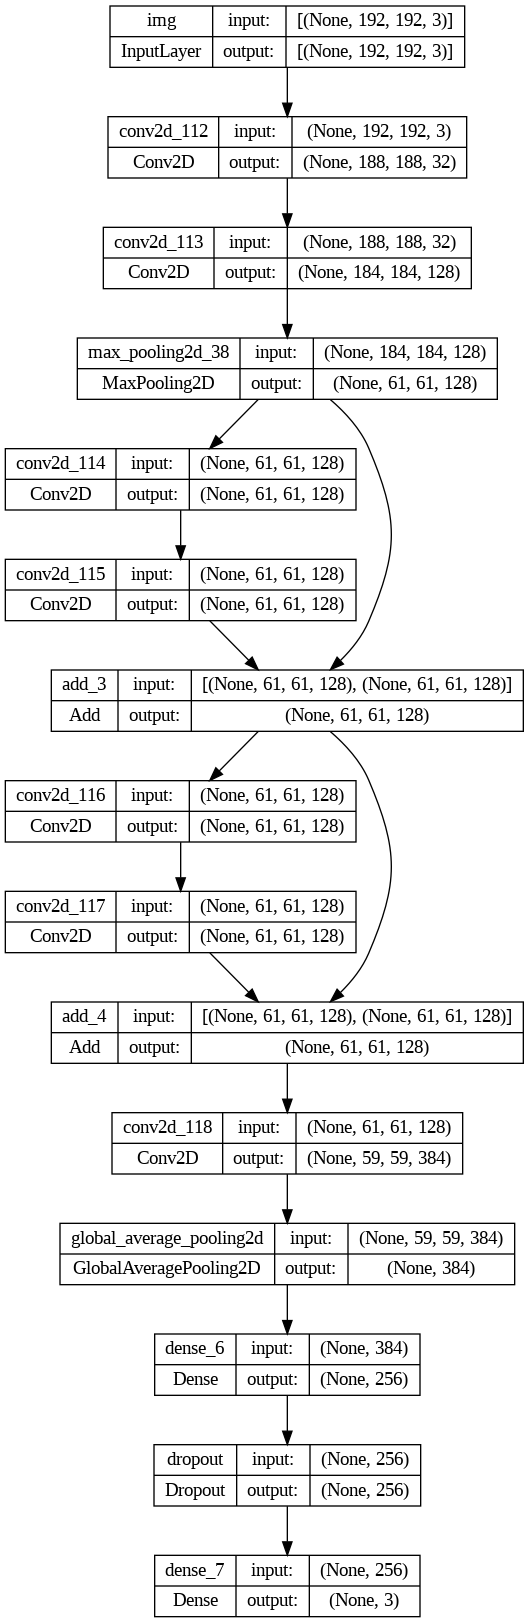

In [ ]:
keras.utils.plot_model(func_model, "functional_api_first.png", show_shapes=True)

In [ ]:
func_model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"],
)

history = func_model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

Epoch 1/2
35/35 [==============================] - 4414s 126s/step - loss: 1.3681 - acc: 0.3335 - val_loss: 1.0983 - val_acc: 0.3406
Epoch 2/2
35/35 [==============================] - 4351s 125s/step - loss: 1.0995 - acc: 0.3490 - val_loss: 1.0994 - val_acc: 0.3206


In [ ]:
func_model.save("func_model.h5", save_format="h5")

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(func_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("func_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feb25693550>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=func_model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 701s 17s/step


In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "func_model.onnx",
                        preprocessor_filepath="preprocessor.zip",
                        prediction_submission=prediction_labels
                        )

Insert search tags to help users find your model (optional): v4
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 159

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### *Model 5 : Squeeze Net Model*


In [ ]:
# Adding batch normalization to assist with optimization for deeper network
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(1234)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand, kernel_size=3, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand, kernel_size=5, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=3)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=3)(y)
  y = fire_module(64, 128)(y)
  y = layers.Dropout(0.5)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=3)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=3)(y)
  y = fire_module(96, 512)(y)
  y = layers.Dropout(0.5)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  fire_model = tf.keras.Model(x, y)
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

  fire_model.compile(
    optimizer='SGD',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  #fire_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
  fire_model.fit(X_train, y_train,epochs = 5, verbose=1,validation_split=.3, callbacks = [red_lr])

Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7106

60/60 [==============================] - 35s 525ms/step - loss: 0.6740 - accuracy: 0.7106 - val_loss: 1.1280 - val_accuracy: 0.3135 - lr: 0.0100
Epoch 2/5
60/60 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8457

60/60 [==============================] - 26s 434ms/step - loss: 0.3979 - accuracy: 0.8457 - val_loss: 1.2155 - val_accuracy: 0.4605 - lr: 0.0100
Epoch 3/5
60/60 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.9009

60/60 [==============================] - 26s 432ms/step - loss: 0.2672 - accuracy: 0.9009 - val_loss: 1.2858 - val_accuracy: 0.5553 - lr: 0.0100
Epoch 4/5
60/60 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9317

60/60 [==============================] - 26s 431ms/step - loss: 0.1964 - accuracy: 0.9317 - val_loss: 1.4295 - val_accuracy: 0.4289 - lr: 0.0100
Epoch 5/5
60/60 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9348

60/60 [==============================] - 26s 433ms/step - loss: 0.1696 - accuracy: 0.9348 - val_loss: 2.0274 - val_accuracy: 0.3913 - lr: 0.0100


### *Model 6 : VGG16 and VGG19 Models*


### **VGG16**

In [ ]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
output = Dense(3, activation='softmax')(class2)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 5, verbose=1,validation_split=.4,callbacks=[mc,red_lr])

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1644/1644 [==============================] - ETA: 0s - loss: 1.1393 - acc: 0.3206

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_acc improved from -inf to 0.34093, saving model to best_model.h5
1644/1644 [==============================] - 1493s 907ms/step - loss: 1.1393 - acc: 0.3206 - val_loss: 1.1240 - val_acc: 0.3409 - lr: 0.0100
Epoch 2/5
1644/1644 [==============================] - ETA: 0s - loss: 1.1005 - acc: 0.3364
Epoch 00002: val_acc did not improve from 0.34093
1644/1644 [==============================] - 1491s 907ms/step - loss: 1.1005 - acc: 0.3364 - val_loss: 1.0995 - val_acc: 0.3355 - lr: 0.0100
Epoch 3/5
1644/1644 [==============================] - ETA: 0s - loss: 1.1011 - acc: 0.3309
Epoch 00003: val_acc did not improve from 0.34093

Epoch 0

### **VGG19**

In [31]:
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(input_shape=(192,192,3),weights='imagenet',include_top=False)
vgg19_model.trainable = False
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [7]:
# for layer in vgg19_model.layers[:-5]:
#     layer.trainable=False

# vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.layers import Dense,GlobalAveragePooling2D

x=vgg19_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x) 
x=Dense(256,activation='relu')(x)
preds=Dense(3, activation='softmax')(x)

In [33]:
vgg19_model=Model(inputs=vgg19_model.input,outputs=preds)

In [34]:
# Fit VGG19 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('vgg19_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  vgg19_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  vgg19_model.fit(X_train, y_train,batch_size=2,
          epochs = 4, verbose=1,validation_split=.25,callbacks=[mc,red_lr])

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1028/1028 [==============================] - ETA: 0s - loss: 0.9316 - acc: 0.5421WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd07b22eca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_acc improved from -inf to 0.32216, saving model to vgg19_model.h5


In [35]:
vgg19_model.save("vgg19_model.h5", save_format="h5")

# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(vgg19_model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("vgg19_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())



#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=vgg19_model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fd075ea63a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 838s 20s/step


In [36]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "vgg19_model.onnx",
                        preprocessor_filepath="preprocessor.zip",
                        prediction_submission=prediction_labels
                        )

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 207

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [37]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

#### **Summary**:
<ul type= "none">
  <li> Below are the list of the models tried for this image classification task: </li>
  <ul>
  <li>  Sequential, Functional API, Squeeze Net, VGG16 and VGG19 </li>
  </ul>


> **Key takeways**

<ul type= "none"> 
  <li>   </li>
  <ul> 
  <li> Use of kernel regulizers (L1 and L2) in the Sequential keras model decreased the training accuracy by almost half and validation accuracy reduced as well with little or no improvement with every epoch </li>
  <li> Batch normalization also deteriorated model performance in the Sequential keras model </li>
  <li> Squeezenet (fire modules) resulted in high training accuracy but low validation accuracy. Overfitting was attempted to be resolved using Batch Normalisation and Dropout. However, results did not improve much. With more resources and time at hand, further model tuning can be explored to get a better model fit  </li>
  <li> VGG16 did not give good results with unfreezing last 5 layers as well as freezing all the layers </li>
  <li> VGG19 performed better in comparison to VGG16. As the model results show training accuracy is increasing in 4 epochs run. Strangely, validation accuracy exceeds the training accuracy in last two epochs </li>
  <li> With access to paid resources of collab, further iterations of the above architectures will be explored. Currently, Sequential Keras model gave the best model results on the leaderboard. </li>